In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

In [2]:
IMAGE_SIZE = 60
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20
RANDOM_IMAGES_NUMBER = 9999

In [3]:
def get_random_no_images(RANDOM_IMAGES_NUMBER = 4499, activate = False):
    if activate:
        all_images_0 = os.listdir(r'.\sliced_images_folder\all_images_jpg\no')
        random.shuffle(all_images_0)
        dir_path = r'.\sliced_images_folder\all_images_less_no\no'
        shutil.rmtree(dir_path)
        os.mkdir(dir_path)

        for i in range (RANDOM_IMAGES_NUMBER):
            original = fr'.\sliced_images_folder\all_images_jpg\no\{all_images_0[i]}'
            target = fr'.\sliced_images_folder\all_images_less_no\no\{all_images_0[i]}'
            shutil.copyfile(original, target)

In [4]:
get_random_no_images(RANDOM_IMAGES_NUMBER, activate = False)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'sliced_images_folder/all_images_less_no',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 14498 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [7]:
len(dataset)

454

In [8]:
def get_dataset_partitions_tf(ds, train_split = 0.6, val_split = 0.2, test_split = 0.2, shuffle_size = 10000, shuffle = True):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
print(len(train_ds), len(val_ds), len(test_ds))

272 90 92


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [15]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true, y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_true, y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall) / (precision + recall + K.epsilon()))

In [17]:
model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(300, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(150, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(75, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'sigmoid')
])

model.build(input_shape = input_shape)

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),    # losst minimalizálni -> f1 score nőhet, 1 - f1score
    #metrics = ['accuracy', f1_metric]# f1 score - precision / recall
    metrics = ['accuracy']          # precision, recallt bele írni, 0 vagy 1-eseket írja
    #metrics = ['acc', f1_m, precision_m, recall_m]
)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60, 60, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 300)       8400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 300)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 150)       405150    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 150)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 75)       

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
272/272 [==============================] - 11s 38ms/step - loss: 0.6239 - accuracy: 0.6861 - val_loss: 0.6222 - val_accuracy: 0.6861
Epoch 2/20
272/272 [==============================] - 10s 37ms/step - loss: 0.6262 - accuracy: 0.6862 - val_loss: 0.6260 - val_accuracy: 0.6861
Epoch 3/20
272/272 [==============================] - 10s 37ms/step - loss: 0.6256 - accuracy: 0.6861 - val_loss: 0.6242 - val_accuracy: 0.6861
Epoch 4/20
272/272 [==============================] - 10s 37ms/step - loss: 0.6236 - accuracy: 0.6861 - val_loss: 0.6242 - val_accuracy: 0.6861
Epoch 5/20
272/272 [==============================] - 10s 37ms/step - loss: 0.4885 - accuracy: 0.7808 - val_loss: 0.3496 - val_accuracy: 0.8841
Epoch 6/20
272/272 [==============================] - 10s 37ms/step - loss: 0.3062 - accuracy: 0.8892 - val_loss: 0.2814 - val_accuracy: 0.9044
Epoch 7/20
272/272 [==============================] - 10s 37ms/step - loss: 0.2923 - accuracy: 0.8988 - val_loss: 0.2773 - val_accuracy:

In [24]:
scores = model.evaluate(test_ds)

272/272 [==============================] - 3s 12ms/step - loss: 0.2490 - accuracy: 0.9140


In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


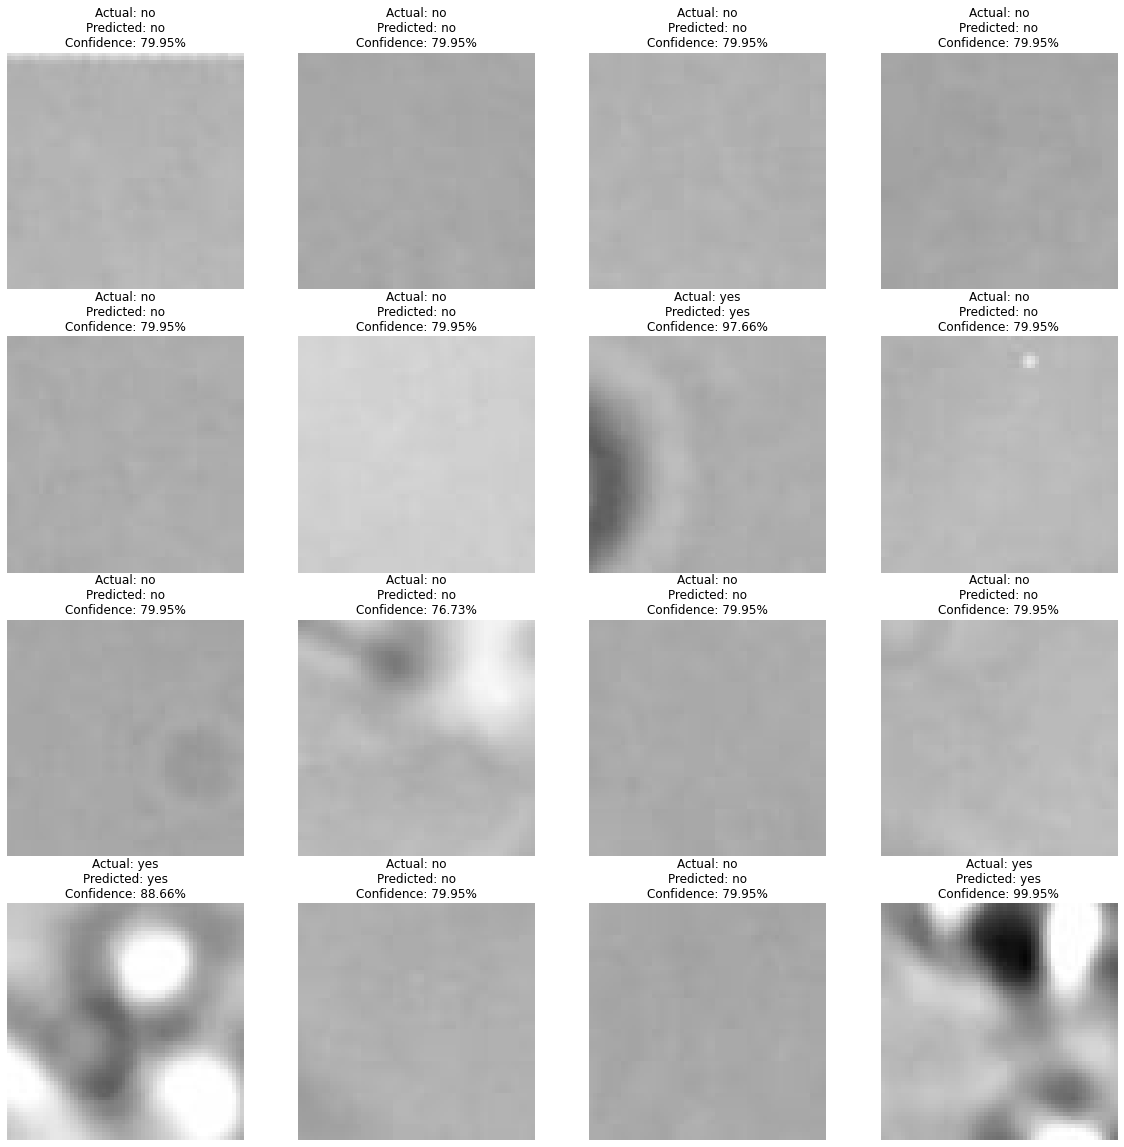

In [26]:
plt.figure(figsize = (20, 20))
for images, labels in test_ds.skip(2).take(1):
    for i in range (16):
        ax = plt.subplot(4,4,i+1) 
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis('off')

In [27]:
model_version = 2
model.save(f'./models/{model_version}')

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

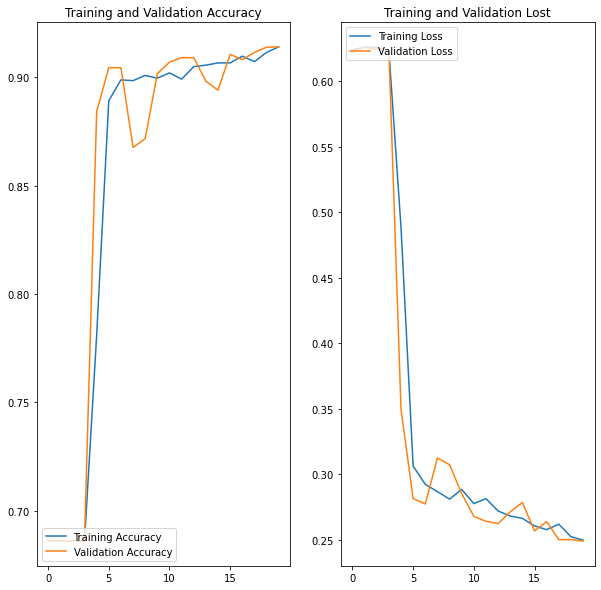

In [29]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.title('Training and Validation Lost')
plt.show()

In [38]:
y_test = []
y_test_images = []
for images, labels in test_ds:
    for label in labels:
        y_test.append(label.numpy())
    for image in images:
        y_test_images.append(image)

In [41]:
y_predicted = model.predict(test_ds)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

272/272 [==============================] - 3s 11ms/step


In [48]:
y_predicted = model.predict(test_ds.take(1))
y_predicted_labels = [np.argmax(i) for i in y_predicted]

1/1 [==============================] - 0s 17ms/step


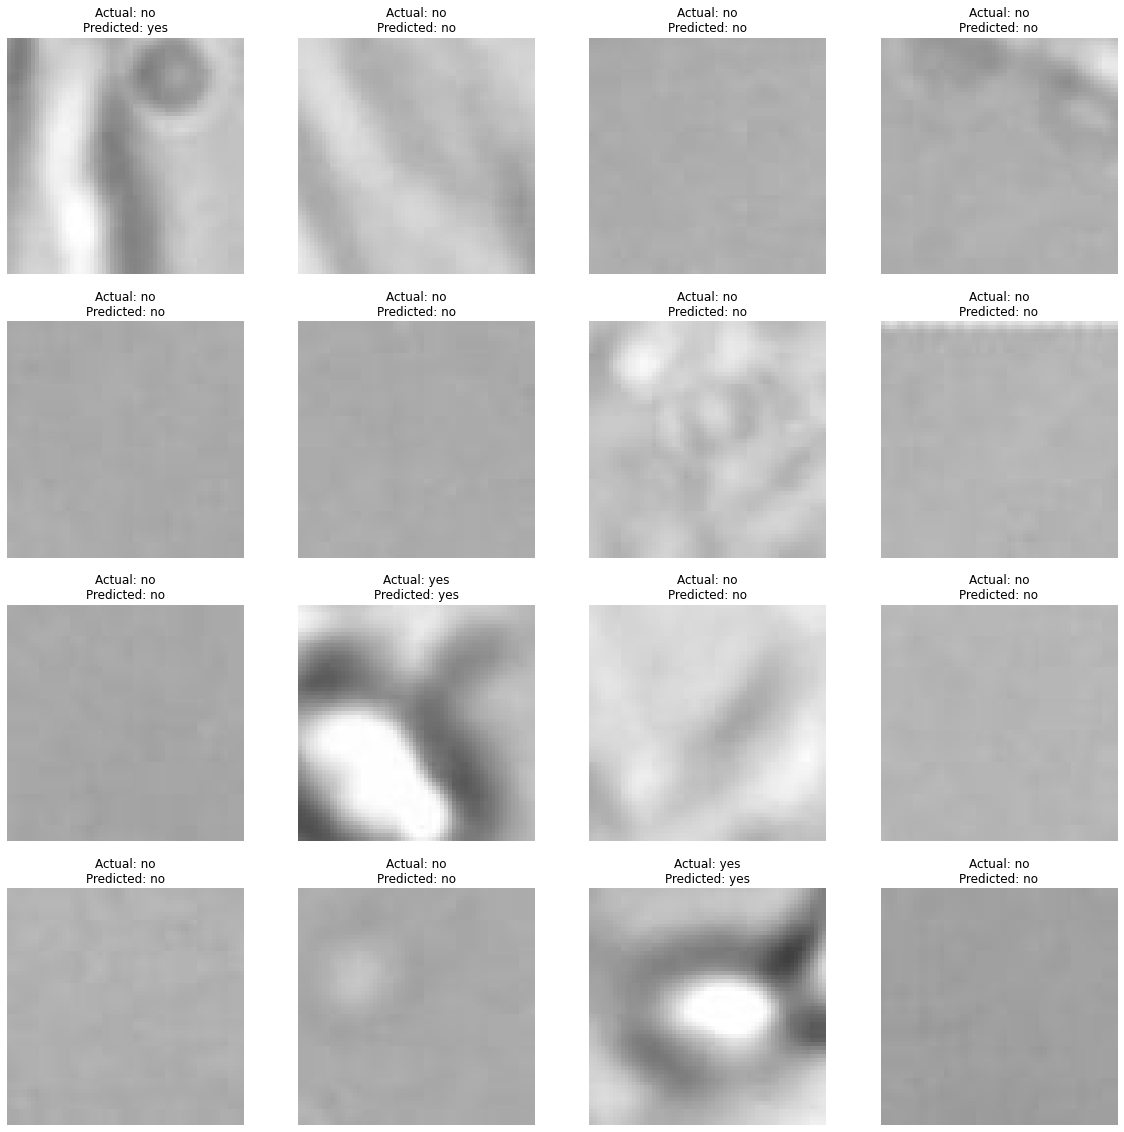

In [59]:
plt.figure(figsize = (20, 20))
for i in range (16):
    ax = plt.subplot(4, 4, i + 1)
    kep = y_test_images[i]
    
    plt.imshow(kep.numpy().astype('uint8'))
    
    kep = kep.numpy()
    kep = np.reshape(kep, [1, 60, 60, 3])
    plt.title(f'Actual: {class_names[y_test[i]]}\nPredicted: {class_names[np.argmax(model.predict(kep, verbose = 0))]}')
    plt.axis('off')

In [53]:
# test ds-re új prediktálás (8673db kép)

y_predicted_label = []
for i in range (len(y_test)):
    print(i)
    y_predicted_label.append(np.argmax(model.predict(np.reshape(y_test_images[i], [1, 60, 60, 3]), verbose = 1)))

0
1/1 [==============================] - 0s 15ms/step
1
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 13ms/step
3
1/1 [==============================] - 0s 14ms/step
4
1/1 [==============================] - 0s 13ms/step
5
1/1 [==============================] - 0s 14ms/step
6
1/1 [==============================] - 0s 13ms/step
7
1/1 [==============================] - 0s 14ms/step
8
1/1 [==============================] - 0s 14ms/step
9
1/1 [==============================] - 0s 14ms/step
10
1/1 [==============================] - 0s 14ms/step
11
1/1 [==============================] - 0s 14ms/step
12
1/1 [==============================] - 0s 13ms/step
13
1/1 [==============================] - 0s 14ms/step
14
1/1 [==============================] - 0s 13ms/step
15
1/1 [==============================] - 0s 14ms/step
16
1/1 [==============================] - 0s 14ms/step
17
1/1 [==============================] - 0s 13ms/step
18
1/1 [============

1/1 [==============================] - 0s 13ms/step
149
1/1 [==============================] - 0s 14ms/step
150
1/1 [==============================] - 0s 13ms/step
151
1/1 [==============================] - 0s 14ms/step
152
1/1 [==============================] - 0s 13ms/step
153
1/1 [==============================] - 0s 13ms/step
154
1/1 [==============================] - 0s 14ms/step
155
1/1 [==============================] - 0s 14ms/step
156
1/1 [==============================] - 0s 13ms/step
157
1/1 [==============================] - 0s 13ms/step
158
1/1 [==============================] - 0s 13ms/step
159
1/1 [==============================] - 0s 14ms/step
160
1/1 [==============================] - 0s 13ms/step
161
1/1 [==============================] - 0s 13ms/step
162
1/1 [==============================] - 0s 13ms/step
163
1/1 [==============================] - 0s 13ms/step
164
1/1 [==============================] - 0s 14ms/step
165
1/1 [==============================] - 0s 14ms/s

1/1 [==============================] - 0s 14ms/step
295
1/1 [==============================] - 0s 13ms/step
296
1/1 [==============================] - 0s 14ms/step
297
1/1 [==============================] - 0s 14ms/step
298
1/1 [==============================] - 0s 13ms/step
299
1/1 [==============================] - 0s 14ms/step
300
1/1 [==============================] - 0s 13ms/step
301
1/1 [==============================] - 0s 13ms/step
302
1/1 [==============================] - 0s 13ms/step
303
1/1 [==============================] - 0s 14ms/step
304
1/1 [==============================] - 0s 13ms/step
305
1/1 [==============================] - 0s 13ms/step
306
1/1 [==============================] - 0s 13ms/step
307
1/1 [==============================] - 0s 14ms/step
308
1/1 [==============================] - 0s 15ms/step
309
1/1 [==============================] - 0s 15ms/step
310
1/1 [==============================] - 0s 13ms/step
311
1/1 [==============================] - 0s 14ms/s

1/1 [==============================] - 0s 14ms/step
441
1/1 [==============================] - 0s 13ms/step
442
1/1 [==============================] - 0s 14ms/step
443
1/1 [==============================] - 0s 14ms/step
444
1/1 [==============================] - 0s 13ms/step
445
1/1 [==============================] - 0s 13ms/step
446
1/1 [==============================] - 0s 14ms/step
447
1/1 [==============================] - 0s 14ms/step
448
1/1 [==============================] - 0s 14ms/step
449
1/1 [==============================] - 0s 14ms/step
450
1/1 [==============================] - 0s 14ms/step
451
1/1 [==============================] - 0s 13ms/step
452
1/1 [==============================] - 0s 13ms/step
453
1/1 [==============================] - 0s 15ms/step
454
1/1 [==============================] - 0s 15ms/step
455
1/1 [==============================] - 0s 15ms/step
456
1/1 [==============================] - 0s 14ms/step
457
1/1 [==============================] - 0s 14ms/s

1/1 [==============================] - 0s 14ms/step
587
1/1 [==============================] - 0s 14ms/step
588
1/1 [==============================] - 0s 13ms/step
589
1/1 [==============================] - 0s 13ms/step
590
1/1 [==============================] - 0s 14ms/step
591
1/1 [==============================] - 0s 15ms/step
592
1/1 [==============================] - 0s 14ms/step
593
1/1 [==============================] - 0s 13ms/step
594
1/1 [==============================] - 0s 13ms/step
595
1/1 [==============================] - 0s 13ms/step
596
1/1 [==============================] - 0s 14ms/step
597
1/1 [==============================] - 0s 14ms/step
598
1/1 [==============================] - 0s 13ms/step
599
1/1 [==============================] - 0s 15ms/step
600
1/1 [==============================] - 0s 14ms/step
601
1/1 [==============================] - 0s 14ms/step
602
1/1 [==============================] - 0s 14ms/step
603
1/1 [==============================] - 0s 13ms/s

1/1 [==============================] - 0s 13ms/step
733
1/1 [==============================] - 0s 13ms/step
734
1/1 [==============================] - 0s 14ms/step
735
1/1 [==============================] - 0s 14ms/step
736
1/1 [==============================] - 0s 14ms/step
737
1/1 [==============================] - 0s 13ms/step
738
1/1 [==============================] - 0s 13ms/step
739
1/1 [==============================] - 0s 14ms/step
740
1/1 [==============================] - 0s 14ms/step
741
1/1 [==============================] - 0s 13ms/step
742
1/1 [==============================] - 0s 14ms/step
743
1/1 [==============================] - 0s 14ms/step
744
1/1 [==============================] - 0s 14ms/step
745
1/1 [==============================] - 0s 14ms/step
746
1/1 [==============================] - 0s 14ms/step
747
1/1 [==============================] - 0s 14ms/step
748
1/1 [==============================] - 0s 13ms/step
749
1/1 [==============================] - 0s 14ms/s

1/1 [==============================] - 0s 13ms/step
879
1/1 [==============================] - 0s 14ms/step
880
1/1 [==============================] - 0s 14ms/step
881
1/1 [==============================] - 0s 13ms/step
882
1/1 [==============================] - 0s 14ms/step
883
1/1 [==============================] - 0s 14ms/step
884
1/1 [==============================] - 0s 13ms/step
885
1/1 [==============================] - 0s 14ms/step
886
1/1 [==============================] - 0s 14ms/step
887
1/1 [==============================] - 0s 14ms/step
888
1/1 [==============================] - 0s 13ms/step
889
1/1 [==============================] - 0s 14ms/step
890
1/1 [==============================] - 0s 14ms/step
891
1/1 [==============================] - 0s 14ms/step
892
1/1 [==============================] - 0s 14ms/step
893
1/1 [==============================] - 0s 14ms/step
894
1/1 [==============================] - 0s 13ms/step
895
1/1 [==============================] - 0s 14ms/s

1024
1/1 [==============================] - 0s 13ms/step
1025
1/1 [==============================] - 0s 15ms/step
1026
1/1 [==============================] - 0s 15ms/step
1027
1/1 [==============================] - 0s 14ms/step
1028
1/1 [==============================] - 0s 14ms/step
1029
1/1 [==============================] - 0s 14ms/step
1030
1/1 [==============================] - 0s 14ms/step
1031
1/1 [==============================] - 0s 14ms/step
1032
1/1 [==============================] - 0s 13ms/step
1033
1/1 [==============================] - 0s 14ms/step
1034
1/1 [==============================] - 0s 13ms/step
1035
1/1 [==============================] - 0s 14ms/step
1036
1/1 [==============================] - 0s 14ms/step
1037
1/1 [==============================] - 0s 14ms/step
1038
1/1 [==============================] - 0s 14ms/step
1039
1/1 [==============================] - 0s 14ms/step
1040
1/1 [==============================] - 0s 19ms/step
1041
1/1 [=====================

1/1 [==============================] - 0s 14ms/step
1168
1/1 [==============================] - 0s 15ms/step
1169
1/1 [==============================] - 0s 13ms/step
1170
1/1 [==============================] - 0s 13ms/step
1171
1/1 [==============================] - 0s 15ms/step
1172
1/1 [==============================] - 0s 14ms/step
1173
1/1 [==============================] - 0s 13ms/step
1174
1/1 [==============================] - 0s 14ms/step
1175
1/1 [==============================] - 0s 14ms/step
1176
1/1 [==============================] - 0s 13ms/step
1177
1/1 [==============================] - 0s 15ms/step
1178
1/1 [==============================] - 0s 14ms/step
1179
1/1 [==============================] - 0s 14ms/step
1180
1/1 [==============================] - 0s 13ms/step
1181
1/1 [==============================] - 0s 14ms/step
1182
1/1 [==============================] - 0s 13ms/step
1183
1/1 [==============================] - 0s 13ms/step
1184
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
1311
1/1 [==============================] - 0s 14ms/step
1312
1/1 [==============================] - 0s 14ms/step
1313
1/1 [==============================] - 0s 13ms/step
1314
1/1 [==============================] - 0s 14ms/step
1315
1/1 [==============================] - 0s 14ms/step
1316
1/1 [==============================] - 0s 14ms/step
1317
1/1 [==============================] - 0s 14ms/step
1318
1/1 [==============================] - 0s 14ms/step
1319
1/1 [==============================] - 0s 13ms/step
1320
1/1 [==============================] - 0s 14ms/step
1321
1/1 [==============================] - 0s 14ms/step
1322
1/1 [==============================] - 0s 13ms/step
1323
1/1 [==============================] - 0s 13ms/step
1324
1/1 [==============================] - 0s 14ms/step
1325
1/1 [==============================] - 0s 14ms/step
1326
1/1 [==============================] - 0s 14ms/step
1327
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
1454
1/1 [==============================] - 0s 13ms/step
1455
1/1 [==============================] - 0s 14ms/step
1456
1/1 [==============================] - 0s 13ms/step
1457
1/1 [==============================] - 0s 14ms/step
1458
1/1 [==============================] - 0s 14ms/step
1459
1/1 [==============================] - 0s 14ms/step
1460
1/1 [==============================] - 0s 13ms/step
1461
1/1 [==============================] - 0s 14ms/step
1462
1/1 [==============================] - 0s 14ms/step
1463
1/1 [==============================] - 0s 13ms/step
1464
1/1 [==============================] - 0s 14ms/step
1465
1/1 [==============================] - 0s 14ms/step
1466
1/1 [==============================] - 0s 13ms/step
1467
1/1 [==============================] - 0s 15ms/step
1468
1/1 [==============================] - 0s 14ms/step
1469
1/1 [==============================] - 0s 14ms/step
1470
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
1597
1/1 [==============================] - 0s 13ms/step
1598
1/1 [==============================] - 0s 13ms/step
1599
1/1 [==============================] - 0s 13ms/step
1600
1/1 [==============================] - 0s 13ms/step
1601
1/1 [==============================] - 0s 13ms/step
1602
1/1 [==============================] - 0s 14ms/step
1603
1/1 [==============================] - 0s 14ms/step
1604
1/1 [==============================] - 0s 13ms/step
1605
1/1 [==============================] - 0s 14ms/step
1606
1/1 [==============================] - 0s 14ms/step
1607
1/1 [==============================] - 0s 14ms/step
1608
1/1 [==============================] - 0s 13ms/step
1609
1/1 [==============================] - 0s 14ms/step
1610
1/1 [==============================] - 0s 14ms/step
1611
1/1 [==============================] - 0s 13ms/step
1612
1/1 [==============================] - 0s 14ms/step
1613
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
1740
1/1 [==============================] - 0s 14ms/step
1741
1/1 [==============================] - 0s 13ms/step
1742
1/1 [==============================] - 0s 14ms/step
1743
1/1 [==============================] - 0s 14ms/step
1744
1/1 [==============================] - 0s 14ms/step
1745
1/1 [==============================] - 0s 13ms/step
1746
1/1 [==============================] - 0s 14ms/step
1747
1/1 [==============================] - 0s 14ms/step
1748
1/1 [==============================] - 0s 14ms/step
1749
1/1 [==============================] - 0s 14ms/step
1750
1/1 [==============================] - 0s 14ms/step
1751
1/1 [==============================] - 0s 14ms/step
1752
1/1 [==============================] - 0s 13ms/step
1753
1/1 [==============================] - 0s 13ms/step
1754
1/1 [==============================] - 0s 14ms/step
1755
1/1 [==============================] - 0s 14ms/step
1756
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
1883
1/1 [==============================] - 0s 14ms/step
1884
1/1 [==============================] - 0s 13ms/step
1885
1/1 [==============================] - 0s 14ms/step
1886
1/1 [==============================] - 0s 13ms/step
1887
1/1 [==============================] - 0s 13ms/step
1888
1/1 [==============================] - 0s 14ms/step
1889
1/1 [==============================] - 0s 14ms/step
1890
1/1 [==============================] - 0s 14ms/step
1891
1/1 [==============================] - 0s 13ms/step
1892
1/1 [==============================] - 0s 13ms/step
1893
1/1 [==============================] - 0s 15ms/step
1894
1/1 [==============================] - 0s 13ms/step
1895
1/1 [==============================] - 0s 13ms/step
1896
1/1 [==============================] - 0s 14ms/step
1897
1/1 [==============================] - 0s 14ms/step
1898
1/1 [==============================] - 0s 13ms/step
1899
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2026
1/1 [==============================] - 0s 15ms/step
2027
1/1 [==============================] - 0s 15ms/step
2028
1/1 [==============================] - 0s 14ms/step
2029
1/1 [==============================] - 0s 14ms/step
2030
1/1 [==============================] - 0s 13ms/step
2031
1/1 [==============================] - 0s 14ms/step
2032
1/1 [==============================] - 0s 14ms/step
2033
1/1 [==============================] - 0s 14ms/step
2034
1/1 [==============================] - 0s 13ms/step
2035
1/1 [==============================] - 0s 14ms/step
2036
1/1 [==============================] - 0s 14ms/step
2037
1/1 [==============================] - 0s 14ms/step
2038
1/1 [==============================] - 0s 14ms/step
2039
1/1 [==============================] - 0s 13ms/step
2040
1/1 [==============================] - 0s 14ms/step
2041
1/1 [==============================] - 0s 14ms/step
2042
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2169
1/1 [==============================] - 0s 14ms/step
2170
1/1 [==============================] - 0s 13ms/step
2171
1/1 [==============================] - 0s 14ms/step
2172
1/1 [==============================] - 0s 14ms/step
2173
1/1 [==============================] - 0s 14ms/step
2174
1/1 [==============================] - 0s 14ms/step
2175
1/1 [==============================] - 0s 14ms/step
2176
1/1 [==============================] - 0s 14ms/step
2177
1/1 [==============================] - 0s 14ms/step
2178
1/1 [==============================] - 0s 14ms/step
2179
1/1 [==============================] - 0s 13ms/step
2180
1/1 [==============================] - 0s 14ms/step
2181
1/1 [==============================] - 0s 14ms/step
2182
1/1 [==============================] - 0s 14ms/step
2183
1/1 [==============================] - 0s 14ms/step
2184
1/1 [==============================] - 0s 14ms/step
2185
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
2312
1/1 [==============================] - 0s 14ms/step
2313
1/1 [==============================] - 0s 14ms/step
2314
1/1 [==============================] - 0s 14ms/step
2315
1/1 [==============================] - 0s 14ms/step
2316
1/1 [==============================] - 0s 15ms/step
2317
1/1 [==============================] - 0s 14ms/step
2318
1/1 [==============================] - 0s 13ms/step
2319
1/1 [==============================] - 0s 14ms/step
2320
1/1 [==============================] - 0s 14ms/step
2321
1/1 [==============================] - 0s 14ms/step
2322
1/1 [==============================] - 0s 14ms/step
2323
1/1 [==============================] - 0s 14ms/step
2324
1/1 [==============================] - 0s 13ms/step
2325
1/1 [==============================] - 0s 14ms/step
2326
1/1 [==============================] - 0s 14ms/step
2327
1/1 [==============================] - 0s 14ms/step
2328
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2455
1/1 [==============================] - 0s 13ms/step
2456
1/1 [==============================] - 0s 14ms/step
2457
1/1 [==============================] - 0s 13ms/step
2458
1/1 [==============================] - 0s 13ms/step
2459
1/1 [==============================] - 0s 13ms/step
2460
1/1 [==============================] - 0s 15ms/step
2461
1/1 [==============================] - 0s 16ms/step
2462
1/1 [==============================] - 0s 13ms/step
2463
1/1 [==============================] - 0s 13ms/step
2464
1/1 [==============================] - 0s 14ms/step
2465
1/1 [==============================] - 0s 14ms/step
2466
1/1 [==============================] - 0s 13ms/step
2467
1/1 [==============================] - 0s 14ms/step
2468
1/1 [==============================] - 0s 14ms/step
2469
1/1 [==============================] - 0s 13ms/step
2470
1/1 [==============================] - 0s 14ms/step
2471
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2598
1/1 [==============================] - 0s 13ms/step
2599
1/1 [==============================] - 0s 13ms/step
2600
1/1 [==============================] - 0s 13ms/step
2601
1/1 [==============================] - 0s 14ms/step
2602
1/1 [==============================] - 0s 13ms/step
2603
1/1 [==============================] - 0s 13ms/step
2604
1/1 [==============================] - 0s 14ms/step
2605
1/1 [==============================] - 0s 13ms/step
2606
1/1 [==============================] - 0s 14ms/step
2607
1/1 [==============================] - 0s 15ms/step
2608
1/1 [==============================] - 0s 14ms/step
2609
1/1 [==============================] - 0s 14ms/step
2610
1/1 [==============================] - 0s 13ms/step
2611
1/1 [==============================] - 0s 14ms/step
2612
1/1 [==============================] - 0s 14ms/step
2613
1/1 [==============================] - 0s 14ms/step
2614
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2741
1/1 [==============================] - 0s 14ms/step
2742
1/1 [==============================] - 0s 14ms/step
2743
1/1 [==============================] - 0s 14ms/step
2744
1/1 [==============================] - 0s 13ms/step
2745
1/1 [==============================] - 0s 14ms/step
2746
1/1 [==============================] - 0s 14ms/step
2747
1/1 [==============================] - 0s 14ms/step
2748
1/1 [==============================] - 0s 14ms/step
2749
1/1 [==============================] - 0s 13ms/step
2750
1/1 [==============================] - 0s 15ms/step
2751
1/1 [==============================] - 0s 13ms/step
2752
1/1 [==============================] - 0s 14ms/step
2753
1/1 [==============================] - 0s 14ms/step
2754
1/1 [==============================] - 0s 14ms/step
2755
1/1 [==============================] - 0s 14ms/step
2756
1/1 [==============================] - 0s 14ms/step
2757
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2884
1/1 [==============================] - 0s 14ms/step
2885
1/1 [==============================] - 0s 14ms/step
2886
1/1 [==============================] - 0s 15ms/step
2887
1/1 [==============================] - 0s 13ms/step
2888
1/1 [==============================] - 0s 14ms/step
2889
1/1 [==============================] - 0s 14ms/step
2890
1/1 [==============================] - 0s 14ms/step
2891
1/1 [==============================] - 0s 13ms/step
2892
1/1 [==============================] - 0s 13ms/step
2893
1/1 [==============================] - 0s 13ms/step
2894
1/1 [==============================] - 0s 14ms/step
2895
1/1 [==============================] - 0s 14ms/step
2896
1/1 [==============================] - 0s 14ms/step
2897
1/1 [==============================] - 0s 13ms/step
2898
1/1 [==============================] - 0s 14ms/step
2899
1/1 [==============================] - 0s 14ms/step
2900
1/1 [==========================

1/1 [==============================] - 0s 18ms/step
3027
1/1 [==============================] - 0s 18ms/step
3028
1/1 [==============================] - 0s 18ms/step
3029
1/1 [==============================] - 0s 15ms/step
3030
1/1 [==============================] - 0s 15ms/step
3031
1/1 [==============================] - 0s 14ms/step
3032
1/1 [==============================] - 0s 14ms/step
3033
1/1 [==============================] - 0s 0s/step
3034
1/1 [==============================] - 0s 15ms/step
3035
1/1 [==============================] - 0s 599us/step
3036
1/1 [==============================] - 0s 16ms/step
3037
1/1 [==============================] - 0s 13ms/step
3038
1/1 [==============================] - 0s 16ms/step
3039
1/1 [==============================] - 0s 115us/step
3040
1/1 [==============================] - 0s 0s/step
3041
1/1 [==============================] - 0s 8ms/step
3042
1/1 [==============================] - 0s 16ms/step
3043
1/1 [=============================

1/1 [==============================] - 0s 13ms/step
3171
1/1 [==============================] - 0s 14ms/step
3172
1/1 [==============================] - 0s 15ms/step
3173
1/1 [==============================] - 0s 13ms/step
3174
1/1 [==============================] - 0s 13ms/step
3175
1/1 [==============================] - 0s 14ms/step
3176
1/1 [==============================] - 0s 13ms/step
3177
1/1 [==============================] - 0s 13ms/step
3178
1/1 [==============================] - 0s 13ms/step
3179
1/1 [==============================] - 0s 15ms/step
3180
1/1 [==============================] - 0s 14ms/step
3181
1/1 [==============================] - 0s 14ms/step
3182
1/1 [==============================] - 0s 14ms/step
3183
1/1 [==============================] - 0s 15ms/step
3184
1/1 [==============================] - 0s 14ms/step
3185
1/1 [==============================] - 0s 14ms/step
3186
1/1 [==============================] - 0s 13ms/step
3187
1/1 [==========================

1/1 [==============================] - 0s 21ms/step
3315
1/1 [==============================] - 0s 18ms/step
3316
1/1 [==============================] - 0s 21ms/step
3317
1/1 [==============================] - 0s 19ms/step
3318
1/1 [==============================] - 0s 21ms/step
3319
1/1 [==============================] - 0s 23ms/step
3320
1/1 [==============================] - 0s 18ms/step
3321
1/1 [==============================] - 0s 21ms/step
3322
1/1 [==============================] - 0s 20ms/step
3323
1/1 [==============================] - 0s 14ms/step
3324
1/1 [==============================] - 0s 14ms/step
3325
1/1 [==============================] - 0s 15ms/step
3326
1/1 [==============================] - 0s 15ms/step
3327
1/1 [==============================] - 0s 14ms/step
3328
1/1 [==============================] - 0s 15ms/step
3329
1/1 [==============================] - 0s 14ms/step
3330
1/1 [==============================] - 0s 16ms/step
3331
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
3458
1/1 [==============================] - 0s 14ms/step
3459
1/1 [==============================] - 0s 14ms/step
3460
1/1 [==============================] - 0s 14ms/step
3461
1/1 [==============================] - 0s 14ms/step
3462
1/1 [==============================] - 0s 14ms/step
3463
1/1 [==============================] - 0s 14ms/step
3464
1/1 [==============================] - 0s 14ms/step
3465
1/1 [==============================] - 0s 14ms/step
3466
1/1 [==============================] - 0s 14ms/step
3467
1/1 [==============================] - 0s 14ms/step
3468
1/1 [==============================] - 0s 14ms/step
3469
1/1 [==============================] - 0s 13ms/step
3470
1/1 [==============================] - 0s 14ms/step
3471
1/1 [==============================] - 0s 15ms/step
3472
1/1 [==============================] - 0s 15ms/step
3473
1/1 [==============================] - 0s 14ms/step
3474
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
3601
1/1 [==============================] - 0s 14ms/step
3602
1/1 [==============================] - 0s 14ms/step
3603
1/1 [==============================] - 0s 14ms/step
3604
1/1 [==============================] - 0s 13ms/step
3605
1/1 [==============================] - 0s 14ms/step
3606
1/1 [==============================] - 0s 14ms/step
3607
1/1 [==============================] - 0s 14ms/step
3608
1/1 [==============================] - 0s 14ms/step
3609
1/1 [==============================] - 0s 14ms/step
3610
1/1 [==============================] - 0s 15ms/step
3611
1/1 [==============================] - 0s 14ms/step
3612
1/1 [==============================] - 0s 14ms/step
3613
1/1 [==============================] - 0s 13ms/step
3614
1/1 [==============================] - 0s 14ms/step
3615
1/1 [==============================] - 0s 15ms/step
3616
1/1 [==============================] - 0s 16ms/step
3617
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
3744
1/1 [==============================] - 0s 13ms/step
3745
1/1 [==============================] - 0s 13ms/step
3746
1/1 [==============================] - 0s 13ms/step
3747
1/1 [==============================] - 0s 13ms/step
3748
1/1 [==============================] - 0s 14ms/step
3749
1/1 [==============================] - 0s 13ms/step
3750
1/1 [==============================] - 0s 13ms/step
3751
1/1 [==============================] - 0s 13ms/step
3752
1/1 [==============================] - 0s 13ms/step
3753
1/1 [==============================] - 0s 14ms/step
3754
1/1 [==============================] - 0s 13ms/step
3755
1/1 [==============================] - 0s 13ms/step
3756
1/1 [==============================] - 0s 13ms/step
3757
1/1 [==============================] - 0s 14ms/step
3758
1/1 [==============================] - 0s 13ms/step
3759
1/1 [==============================] - 0s 14ms/step
3760
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
3887
1/1 [==============================] - 0s 14ms/step
3888
1/1 [==============================] - 0s 14ms/step
3889
1/1 [==============================] - 0s 14ms/step
3890
1/1 [==============================] - 0s 13ms/step
3891
1/1 [==============================] - 0s 14ms/step
3892
1/1 [==============================] - 0s 13ms/step
3893
1/1 [==============================] - 0s 14ms/step
3894
1/1 [==============================] - 0s 13ms/step
3895
1/1 [==============================] - 0s 13ms/step
3896
1/1 [==============================] - 0s 14ms/step
3897
1/1 [==============================] - 0s 14ms/step
3898
1/1 [==============================] - 0s 13ms/step
3899
1/1 [==============================] - 0s 14ms/step
3900
1/1 [==============================] - 0s 13ms/step
3901
1/1 [==============================] - 0s 13ms/step
3902
1/1 [==============================] - 0s 14ms/step
3903
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
4030
1/1 [==============================] - 0s 14ms/step
4031
1/1 [==============================] - 0s 13ms/step
4032
1/1 [==============================] - 0s 14ms/step
4033
1/1 [==============================] - 0s 15ms/step
4034
1/1 [==============================] - 0s 13ms/step
4035
1/1 [==============================] - 0s 13ms/step
4036
1/1 [==============================] - 0s 14ms/step
4037
1/1 [==============================] - 0s 13ms/step
4038
1/1 [==============================] - 0s 14ms/step
4039
1/1 [==============================] - 0s 14ms/step
4040
1/1 [==============================] - 0s 14ms/step
4041
1/1 [==============================] - 0s 14ms/step
4042
1/1 [==============================] - 0s 14ms/step
4043
1/1 [==============================] - 0s 14ms/step
4044
1/1 [==============================] - 0s 14ms/step
4045
1/1 [==============================] - 0s 14ms/step
4046
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
4173
1/1 [==============================] - 0s 14ms/step
4174
1/1 [==============================] - 0s 15ms/step
4175
1/1 [==============================] - 0s 15ms/step
4176
1/1 [==============================] - 0s 14ms/step
4177
1/1 [==============================] - 0s 14ms/step
4178
1/1 [==============================] - 0s 14ms/step
4179
1/1 [==============================] - 0s 14ms/step
4180
1/1 [==============================] - 0s 14ms/step
4181
1/1 [==============================] - 0s 15ms/step
4182
1/1 [==============================] - 0s 14ms/step
4183
1/1 [==============================] - 0s 13ms/step
4184
1/1 [==============================] - 0s 14ms/step
4185
1/1 [==============================] - 0s 14ms/step
4186
1/1 [==============================] - 0s 15ms/step
4187
1/1 [==============================] - 0s 14ms/step
4188
1/1 [==============================] - 0s 14ms/step
4189
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
4316
1/1 [==============================] - 0s 14ms/step
4317
1/1 [==============================] - 0s 14ms/step
4318
1/1 [==============================] - 0s 14ms/step
4319
1/1 [==============================] - 0s 14ms/step
4320
1/1 [==============================] - 0s 14ms/step
4321
1/1 [==============================] - 0s 14ms/step
4322
1/1 [==============================] - 0s 14ms/step
4323
1/1 [==============================] - 0s 14ms/step
4324
1/1 [==============================] - 0s 14ms/step
4325
1/1 [==============================] - 0s 14ms/step
4326
1/1 [==============================] - 0s 15ms/step
4327
1/1 [==============================] - 0s 13ms/step
4328
1/1 [==============================] - 0s 14ms/step
4329
1/1 [==============================] - 0s 14ms/step
4330
1/1 [==============================] - 0s 13ms/step
4331
1/1 [==============================] - 0s 14ms/step
4332
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
4459
1/1 [==============================] - 0s 13ms/step
4460
1/1 [==============================] - 0s 14ms/step
4461
1/1 [==============================] - 0s 14ms/step
4462
1/1 [==============================] - 0s 14ms/step
4463
1/1 [==============================] - 0s 14ms/step
4464
1/1 [==============================] - 0s 14ms/step
4465
1/1 [==============================] - 0s 14ms/step
4466
1/1 [==============================] - 0s 14ms/step
4467
1/1 [==============================] - 0s 14ms/step
4468
1/1 [==============================] - 0s 14ms/step
4469
1/1 [==============================] - 0s 14ms/step
4470
1/1 [==============================] - 0s 13ms/step
4471
1/1 [==============================] - 0s 14ms/step
4472
1/1 [==============================] - 0s 14ms/step
4473
1/1 [==============================] - 0s 14ms/step
4474
1/1 [==============================] - 0s 13ms/step
4475
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
4602
1/1 [==============================] - 0s 14ms/step
4603
1/1 [==============================] - 0s 14ms/step
4604
1/1 [==============================] - 0s 14ms/step
4605
1/1 [==============================] - 0s 14ms/step
4606
1/1 [==============================] - 0s 14ms/step
4607
1/1 [==============================] - 0s 14ms/step
4608
1/1 [==============================] - 0s 15ms/step
4609
1/1 [==============================] - 0s 15ms/step
4610
1/1 [==============================] - 0s 14ms/step
4611
1/1 [==============================] - 0s 14ms/step
4612
1/1 [==============================] - 0s 14ms/step
4613
1/1 [==============================] - 0s 14ms/step
4614
1/1 [==============================] - 0s 14ms/step
4615
1/1 [==============================] - 0s 14ms/step
4616
1/1 [==============================] - 0s 14ms/step
4617
1/1 [==============================] - 0s 14ms/step
4618
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
4745
1/1 [==============================] - 0s 15ms/step
4746
1/1 [==============================] - 0s 14ms/step
4747
1/1 [==============================] - 0s 14ms/step
4748
1/1 [==============================] - 0s 14ms/step
4749
1/1 [==============================] - 0s 13ms/step
4750
1/1 [==============================] - 0s 15ms/step
4751
1/1 [==============================] - 0s 13ms/step
4752
1/1 [==============================] - 0s 13ms/step
4753
1/1 [==============================] - 0s 14ms/step
4754
1/1 [==============================] - 0s 14ms/step
4755
1/1 [==============================] - 0s 15ms/step
4756
1/1 [==============================] - 0s 15ms/step
4757
1/1 [==============================] - 0s 14ms/step
4758
1/1 [==============================] - 0s 14ms/step
4759
1/1 [==============================] - 0s 14ms/step
4760
1/1 [==============================] - 0s 14ms/step
4761
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
4888
1/1 [==============================] - 0s 14ms/step
4889
1/1 [==============================] - 0s 15ms/step
4890
1/1 [==============================] - 0s 14ms/step
4891
1/1 [==============================] - 0s 14ms/step
4892
1/1 [==============================] - 0s 14ms/step
4893
1/1 [==============================] - 0s 14ms/step
4894
1/1 [==============================] - 0s 14ms/step
4895
1/1 [==============================] - 0s 14ms/step
4896
1/1 [==============================] - 0s 14ms/step
4897
1/1 [==============================] - 0s 14ms/step
4898
1/1 [==============================] - 0s 14ms/step
4899
1/1 [==============================] - 0s 14ms/step
4900
1/1 [==============================] - 0s 15ms/step
4901
1/1 [==============================] - 0s 14ms/step
4902
1/1 [==============================] - 0s 14ms/step
4903
1/1 [==============================] - 0s 14ms/step
4904
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
5031
1/1 [==============================] - 0s 14ms/step
5032
1/1 [==============================] - 0s 14ms/step
5033
1/1 [==============================] - 0s 14ms/step
5034
1/1 [==============================] - 0s 13ms/step
5035
1/1 [==============================] - 0s 14ms/step
5036
1/1 [==============================] - 0s 14ms/step
5037
1/1 [==============================] - 0s 14ms/step
5038
1/1 [==============================] - 0s 14ms/step
5039
1/1 [==============================] - 0s 14ms/step
5040
1/1 [==============================] - 0s 14ms/step
5041
1/1 [==============================] - 0s 14ms/step
5042
1/1 [==============================] - 0s 14ms/step
5043
1/1 [==============================] - 0s 14ms/step
5044
1/1 [==============================] - 0s 13ms/step
5045
1/1 [==============================] - 0s 14ms/step
5046
1/1 [==============================] - 0s 14ms/step
5047
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
5174
1/1 [==============================] - 0s 14ms/step
5175
1/1 [==============================] - 0s 13ms/step
5176
1/1 [==============================] - 0s 14ms/step
5177
1/1 [==============================] - 0s 14ms/step
5178
1/1 [==============================] - 0s 14ms/step
5179
1/1 [==============================] - 0s 13ms/step
5180
1/1 [==============================] - 0s 13ms/step
5181
1/1 [==============================] - 0s 14ms/step
5182
1/1 [==============================] - 0s 14ms/step
5183
1/1 [==============================] - 0s 14ms/step
5184
1/1 [==============================] - 0s 14ms/step
5185
1/1 [==============================] - 0s 14ms/step
5186
1/1 [==============================] - 0s 14ms/step
5187
1/1 [==============================] - 0s 14ms/step
5188
1/1 [==============================] - 0s 14ms/step
5189
1/1 [==============================] - 0s 15ms/step
5190
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
5317
1/1 [==============================] - 0s 14ms/step
5318
1/1 [==============================] - 0s 14ms/step
5319
1/1 [==============================] - 0s 13ms/step
5320
1/1 [==============================] - 0s 14ms/step
5321
1/1 [==============================] - 0s 13ms/step
5322
1/1 [==============================] - 0s 14ms/step
5323
1/1 [==============================] - 0s 14ms/step
5324
1/1 [==============================] - 0s 14ms/step
5325
1/1 [==============================] - 0s 14ms/step
5326
1/1 [==============================] - 0s 14ms/step
5327
1/1 [==============================] - 0s 14ms/step
5328
1/1 [==============================] - 0s 14ms/step
5329
1/1 [==============================] - 0s 14ms/step
5330
1/1 [==============================] - 0s 13ms/step
5331
1/1 [==============================] - 0s 13ms/step
5332
1/1 [==============================] - 0s 13ms/step
5333
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5460
1/1 [==============================] - 0s 14ms/step
5461
1/1 [==============================] - 0s 14ms/step
5462
1/1 [==============================] - 0s 14ms/step
5463
1/1 [==============================] - 0s 14ms/step
5464
1/1 [==============================] - 0s 15ms/step
5465
1/1 [==============================] - 0s 14ms/step
5466
1/1 [==============================] - 0s 14ms/step
5467
1/1 [==============================] - 0s 14ms/step
5468
1/1 [==============================] - 0s 13ms/step
5469
1/1 [==============================] - 0s 14ms/step
5470
1/1 [==============================] - 0s 14ms/step
5471
1/1 [==============================] - 0s 14ms/step
5472
1/1 [==============================] - 0s 14ms/step
5473
1/1 [==============================] - 0s 14ms/step
5474
1/1 [==============================] - 0s 14ms/step
5475
1/1 [==============================] - 0s 14ms/step
5476
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5603
1/1 [==============================] - 0s 14ms/step
5604
1/1 [==============================] - 0s 14ms/step
5605
1/1 [==============================] - 0s 14ms/step
5606
1/1 [==============================] - 0s 15ms/step
5607
1/1 [==============================] - 0s 14ms/step
5608
1/1 [==============================] - 0s 14ms/step
5609
1/1 [==============================] - 0s 14ms/step
5610
1/1 [==============================] - 0s 14ms/step
5611
1/1 [==============================] - 0s 14ms/step
5612
1/1 [==============================] - 0s 13ms/step
5613
1/1 [==============================] - 0s 13ms/step
5614
1/1 [==============================] - 0s 14ms/step
5615
1/1 [==============================] - 0s 14ms/step
5616
1/1 [==============================] - 0s 14ms/step
5617
1/1 [==============================] - 0s 15ms/step
5618
1/1 [==============================] - 0s 14ms/step
5619
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
5746
1/1 [==============================] - 0s 14ms/step
5747
1/1 [==============================] - 0s 14ms/step
5748
1/1 [==============================] - 0s 13ms/step
5749
1/1 [==============================] - 0s 14ms/step
5750
1/1 [==============================] - 0s 14ms/step
5751
1/1 [==============================] - 0s 13ms/step
5752
1/1 [==============================] - 0s 14ms/step
5753
1/1 [==============================] - 0s 14ms/step
5754
1/1 [==============================] - 0s 13ms/step
5755
1/1 [==============================] - 0s 13ms/step
5756
1/1 [==============================] - 0s 14ms/step
5757
1/1 [==============================] - 0s 15ms/step
5758
1/1 [==============================] - 0s 14ms/step
5759
1/1 [==============================] - 0s 14ms/step
5760
1/1 [==============================] - 0s 14ms/step
5761
1/1 [==============================] - 0s 14ms/step
5762
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
5889
1/1 [==============================] - 0s 13ms/step
5890
1/1 [==============================] - 0s 14ms/step
5891
1/1 [==============================] - 0s 14ms/step
5892
1/1 [==============================] - 0s 14ms/step
5893
1/1 [==============================] - 0s 13ms/step
5894
1/1 [==============================] - 0s 14ms/step
5895
1/1 [==============================] - 0s 14ms/step
5896
1/1 [==============================] - 0s 14ms/step
5897
1/1 [==============================] - 0s 14ms/step
5898
1/1 [==============================] - 0s 13ms/step
5899
1/1 [==============================] - 0s 14ms/step
5900
1/1 [==============================] - 0s 13ms/step
5901
1/1 [==============================] - 0s 14ms/step
5902
1/1 [==============================] - 0s 14ms/step
5903
1/1 [==============================] - 0s 14ms/step
5904
1/1 [==============================] - 0s 14ms/step
5905
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
6032
1/1 [==============================] - 0s 14ms/step
6033
1/1 [==============================] - 0s 14ms/step
6034
1/1 [==============================] - 0s 14ms/step
6035
1/1 [==============================] - 0s 14ms/step
6036
1/1 [==============================] - 0s 14ms/step
6037
1/1 [==============================] - 0s 14ms/step
6038
1/1 [==============================] - 0s 14ms/step
6039
1/1 [==============================] - 0s 14ms/step
6040
1/1 [==============================] - 0s 13ms/step
6041
1/1 [==============================] - 0s 14ms/step
6042
1/1 [==============================] - 0s 14ms/step
6043
1/1 [==============================] - 0s 13ms/step
6044
1/1 [==============================] - 0s 13ms/step
6045
1/1 [==============================] - 0s 13ms/step
6046
1/1 [==============================] - 0s 13ms/step
6047
1/1 [==============================] - 0s 14ms/step
6048
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
6175
1/1 [==============================] - 0s 14ms/step
6176
1/1 [==============================] - 0s 14ms/step
6177
1/1 [==============================] - 0s 14ms/step
6178
1/1 [==============================] - 0s 14ms/step
6179
1/1 [==============================] - 0s 14ms/step
6180
1/1 [==============================] - 0s 14ms/step
6181
1/1 [==============================] - 0s 14ms/step
6182
1/1 [==============================] - 0s 13ms/step
6183
1/1 [==============================] - 0s 15ms/step
6184
1/1 [==============================] - 0s 14ms/step
6185
1/1 [==============================] - 0s 14ms/step
6186
1/1 [==============================] - 0s 15ms/step
6187
1/1 [==============================] - 0s 14ms/step
6188
1/1 [==============================] - 0s 14ms/step
6189
1/1 [==============================] - 0s 13ms/step
6190
1/1 [==============================] - 0s 14ms/step
6191
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
6318
1/1 [==============================] - 0s 14ms/step
6319
1/1 [==============================] - 0s 14ms/step
6320
1/1 [==============================] - 0s 14ms/step
6321
1/1 [==============================] - 0s 14ms/step
6322
1/1 [==============================] - 0s 14ms/step
6323
1/1 [==============================] - 0s 14ms/step
6324
1/1 [==============================] - 0s 14ms/step
6325
1/1 [==============================] - 0s 15ms/step
6326
1/1 [==============================] - 0s 15ms/step
6327
1/1 [==============================] - 0s 14ms/step
6328
1/1 [==============================] - 0s 14ms/step
6329
1/1 [==============================] - 0s 14ms/step
6330
1/1 [==============================] - 0s 15ms/step
6331
1/1 [==============================] - 0s 14ms/step
6332
1/1 [==============================] - 0s 13ms/step
6333
1/1 [==============================] - 0s 15ms/step
6334
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
6461
1/1 [==============================] - 0s 14ms/step
6462
1/1 [==============================] - 0s 15ms/step
6463
1/1 [==============================] - 0s 14ms/step
6464
1/1 [==============================] - 0s 13ms/step
6465
1/1 [==============================] - 0s 13ms/step
6466
1/1 [==============================] - 0s 14ms/step
6467
1/1 [==============================] - 0s 14ms/step
6468
1/1 [==============================] - 0s 14ms/step
6469
1/1 [==============================] - 0s 15ms/step
6470
1/1 [==============================] - 0s 13ms/step
6471
1/1 [==============================] - 0s 14ms/step
6472
1/1 [==============================] - 0s 14ms/step
6473
1/1 [==============================] - 0s 15ms/step
6474
1/1 [==============================] - 0s 13ms/step
6475
1/1 [==============================] - 0s 14ms/step
6476
1/1 [==============================] - 0s 15ms/step
6477
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
6604
1/1 [==============================] - 0s 14ms/step
6605
1/1 [==============================] - 0s 13ms/step
6606
1/1 [==============================] - 0s 14ms/step
6607
1/1 [==============================] - 0s 13ms/step
6608
1/1 [==============================] - 0s 14ms/step
6609
1/1 [==============================] - 0s 14ms/step
6610
1/1 [==============================] - 0s 14ms/step
6611
1/1 [==============================] - 0s 15ms/step
6612
1/1 [==============================] - 0s 13ms/step
6613
1/1 [==============================] - 0s 14ms/step
6614
1/1 [==============================] - 0s 14ms/step
6615
1/1 [==============================] - 0s 13ms/step
6616
1/1 [==============================] - 0s 14ms/step
6617
1/1 [==============================] - 0s 14ms/step
6618
1/1 [==============================] - 0s 14ms/step
6619
1/1 [==============================] - 0s 14ms/step
6620
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
6747
1/1 [==============================] - 0s 14ms/step
6748
1/1 [==============================] - 0s 14ms/step
6749
1/1 [==============================] - 0s 14ms/step
6750
1/1 [==============================] - 0s 14ms/step
6751
1/1 [==============================] - 0s 14ms/step
6752
1/1 [==============================] - 0s 14ms/step
6753
1/1 [==============================] - 0s 14ms/step
6754
1/1 [==============================] - 0s 14ms/step
6755
1/1 [==============================] - 0s 14ms/step
6756
1/1 [==============================] - 0s 14ms/step
6757
1/1 [==============================] - 0s 14ms/step
6758
1/1 [==============================] - 0s 14ms/step
6759
1/1 [==============================] - 0s 14ms/step
6760
1/1 [==============================] - 0s 14ms/step
6761
1/1 [==============================] - 0s 14ms/step
6762
1/1 [==============================] - 0s 14ms/step
6763
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
6890
1/1 [==============================] - 0s 14ms/step
6891
1/1 [==============================] - 0s 14ms/step
6892
1/1 [==============================] - 0s 14ms/step
6893
1/1 [==============================] - 0s 13ms/step
6894
1/1 [==============================] - 0s 14ms/step
6895
1/1 [==============================] - 0s 14ms/step
6896
1/1 [==============================] - 0s 15ms/step
6897
1/1 [==============================] - 0s 13ms/step
6898
1/1 [==============================] - 0s 14ms/step
6899
1/1 [==============================] - 0s 14ms/step
6900
1/1 [==============================] - 0s 14ms/step
6901
1/1 [==============================] - 0s 14ms/step
6902
1/1 [==============================] - 0s 14ms/step
6903
1/1 [==============================] - 0s 13ms/step
6904
1/1 [==============================] - 0s 13ms/step
6905
1/1 [==============================] - 0s 14ms/step
6906
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7033
1/1 [==============================] - 0s 14ms/step
7034
1/1 [==============================] - 0s 13ms/step
7035
1/1 [==============================] - 0s 15ms/step
7036
1/1 [==============================] - 0s 14ms/step
7037
1/1 [==============================] - 0s 14ms/step
7038
1/1 [==============================] - 0s 14ms/step
7039
1/1 [==============================] - 0s 15ms/step
7040
1/1 [==============================] - 0s 13ms/step
7041
1/1 [==============================] - 0s 14ms/step
7042
1/1 [==============================] - 0s 15ms/step
7043
1/1 [==============================] - 0s 14ms/step
7044
1/1 [==============================] - 0s 15ms/step
7045
1/1 [==============================] - 0s 14ms/step
7046
1/1 [==============================] - 0s 14ms/step
7047
1/1 [==============================] - 0s 14ms/step
7048
1/1 [==============================] - 0s 13ms/step
7049
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7176
1/1 [==============================] - 0s 14ms/step
7177
1/1 [==============================] - 0s 15ms/step
7178
1/1 [==============================] - 0s 15ms/step
7179
1/1 [==============================] - 0s 13ms/step
7180
1/1 [==============================] - 0s 14ms/step
7181
1/1 [==============================] - 0s 14ms/step
7182
1/1 [==============================] - 0s 14ms/step
7183
1/1 [==============================] - 0s 14ms/step
7184
1/1 [==============================] - 0s 15ms/step
7185
1/1 [==============================] - 0s 14ms/step
7186
1/1 [==============================] - 0s 14ms/step
7187
1/1 [==============================] - 0s 14ms/step
7188
1/1 [==============================] - 0s 14ms/step
7189
1/1 [==============================] - 0s 15ms/step
7190
1/1 [==============================] - 0s 13ms/step
7191
1/1 [==============================] - 0s 13ms/step
7192
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
7319
1/1 [==============================] - 0s 15ms/step
7320
1/1 [==============================] - 0s 15ms/step
7321
1/1 [==============================] - 0s 14ms/step
7322
1/1 [==============================] - 0s 14ms/step
7323
1/1 [==============================] - 0s 14ms/step
7324
1/1 [==============================] - 0s 14ms/step
7325
1/1 [==============================] - 0s 13ms/step
7326
1/1 [==============================] - 0s 14ms/step
7327
1/1 [==============================] - 0s 14ms/step
7328
1/1 [==============================] - 0s 14ms/step
7329
1/1 [==============================] - 0s 14ms/step
7330
1/1 [==============================] - 0s 14ms/step
7331
1/1 [==============================] - 0s 15ms/step
7332
1/1 [==============================] - 0s 13ms/step
7333
1/1 [==============================] - 0s 13ms/step
7334
1/1 [==============================] - 0s 14ms/step
7335
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7462
1/1 [==============================] - 0s 15ms/step
7463
1/1 [==============================] - 0s 14ms/step
7464
1/1 [==============================] - 0s 14ms/step
7465
1/1 [==============================] - 0s 15ms/step
7466
1/1 [==============================] - 0s 14ms/step
7467
1/1 [==============================] - 0s 14ms/step
7468
1/1 [==============================] - 0s 13ms/step
7469
1/1 [==============================] - 0s 15ms/step
7470
1/1 [==============================] - 0s 14ms/step
7471
1/1 [==============================] - 0s 14ms/step
7472
1/1 [==============================] - 0s 13ms/step
7473
1/1 [==============================] - 0s 14ms/step
7474
1/1 [==============================] - 0s 14ms/step
7475
1/1 [==============================] - 0s 14ms/step
7476
1/1 [==============================] - 0s 15ms/step
7477
1/1 [==============================] - 0s 14ms/step
7478
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7605
1/1 [==============================] - 0s 13ms/step
7606
1/1 [==============================] - 0s 13ms/step
7607
1/1 [==============================] - 0s 14ms/step
7608
1/1 [==============================] - 0s 14ms/step
7609
1/1 [==============================] - 0s 14ms/step
7610
1/1 [==============================] - 0s 14ms/step
7611
1/1 [==============================] - 0s 14ms/step
7612
1/1 [==============================] - 0s 14ms/step
7613
1/1 [==============================] - 0s 14ms/step
7614
1/1 [==============================] - 0s 14ms/step
7615
1/1 [==============================] - 0s 14ms/step
7616
1/1 [==============================] - 0s 14ms/step
7617
1/1 [==============================] - 0s 15ms/step
7618
1/1 [==============================] - 0s 15ms/step
7619
1/1 [==============================] - 0s 13ms/step
7620
1/1 [==============================] - 0s 14ms/step
7621
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7748
1/1 [==============================] - 0s 13ms/step
7749
1/1 [==============================] - 0s 14ms/step
7750
1/1 [==============================] - 0s 14ms/step
7751
1/1 [==============================] - 0s 15ms/step
7752
1/1 [==============================] - 0s 14ms/step
7753
1/1 [==============================] - 0s 14ms/step
7754
1/1 [==============================] - 0s 14ms/step
7755
1/1 [==============================] - 0s 15ms/step
7756
1/1 [==============================] - 0s 14ms/step
7757
1/1 [==============================] - 0s 14ms/step
7758
1/1 [==============================] - 0s 13ms/step
7759
1/1 [==============================] - 0s 14ms/step
7760
1/1 [==============================] - 0s 14ms/step
7761
1/1 [==============================] - 0s 20ms/step
7762
1/1 [==============================] - 0s 14ms/step
7763
1/1 [==============================] - 0s 14ms/step
7764
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7891
1/1 [==============================] - 0s 14ms/step
7892
1/1 [==============================] - 0s 15ms/step
7893
1/1 [==============================] - 0s 14ms/step
7894
1/1 [==============================] - 0s 14ms/step
7895
1/1 [==============================] - 0s 14ms/step
7896
1/1 [==============================] - 0s 14ms/step
7897
1/1 [==============================] - 0s 14ms/step
7898
1/1 [==============================] - 0s 14ms/step
7899
1/1 [==============================] - 0s 14ms/step
7900
1/1 [==============================] - 0s 15ms/step
7901
1/1 [==============================] - 0s 15ms/step
7902
1/1 [==============================] - 0s 15ms/step
7903
1/1 [==============================] - 0s 15ms/step
7904
1/1 [==============================] - 0s 14ms/step
7905
1/1 [==============================] - 0s 14ms/step
7906
1/1 [==============================] - 0s 14ms/step
7907
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
8034
1/1 [==============================] - 0s 15ms/step
8035
1/1 [==============================] - 0s 14ms/step
8036
1/1 [==============================] - 0s 13ms/step
8037
1/1 [==============================] - 0s 14ms/step
8038
1/1 [==============================] - 0s 14ms/step
8039
1/1 [==============================] - 0s 13ms/step
8040
1/1 [==============================] - 0s 15ms/step
8041
1/1 [==============================] - 0s 15ms/step
8042
1/1 [==============================] - 0s 14ms/step
8043
1/1 [==============================] - 0s 13ms/step
8044
1/1 [==============================] - 0s 14ms/step
8045
1/1 [==============================] - 0s 14ms/step
8046
1/1 [==============================] - 0s 14ms/step
8047
1/1 [==============================] - 0s 14ms/step
8048
1/1 [==============================] - 0s 15ms/step
8049
1/1 [==============================] - 0s 15ms/step
8050
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
8177
1/1 [==============================] - 0s 14ms/step
8178
1/1 [==============================] - 0s 14ms/step
8179
1/1 [==============================] - 0s 14ms/step
8180
1/1 [==============================] - 0s 14ms/step
8181
1/1 [==============================] - 0s 14ms/step
8182
1/1 [==============================] - 0s 14ms/step
8183
1/1 [==============================] - 0s 14ms/step
8184
1/1 [==============================] - 0s 15ms/step
8185
1/1 [==============================] - 0s 14ms/step
8186
1/1 [==============================] - 0s 14ms/step
8187
1/1 [==============================] - 0s 14ms/step
8188
1/1 [==============================] - 0s 14ms/step
8189
1/1 [==============================] - 0s 13ms/step
8190
1/1 [==============================] - 0s 14ms/step
8191
1/1 [==============================] - 0s 14ms/step
8192
1/1 [==============================] - 0s 14ms/step
8193
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
8320
1/1 [==============================] - 0s 14ms/step
8321
1/1 [==============================] - 0s 13ms/step
8322
1/1 [==============================] - 0s 16ms/step
8323
1/1 [==============================] - 0s 14ms/step
8324
1/1 [==============================] - 0s 14ms/step
8325
1/1 [==============================] - 0s 14ms/step
8326
1/1 [==============================] - 0s 14ms/step
8327
1/1 [==============================] - 0s 14ms/step
8328
1/1 [==============================] - 0s 14ms/step
8329
1/1 [==============================] - 0s 15ms/step
8330
1/1 [==============================] - 0s 14ms/step
8331
1/1 [==============================] - 0s 14ms/step
8332
1/1 [==============================] - 0s 13ms/step
8333
1/1 [==============================] - 0s 13ms/step
8334
1/1 [==============================] - 0s 14ms/step
8335
1/1 [==============================] - 0s 14ms/step
8336
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
8463
1/1 [==============================] - 0s 14ms/step
8464
1/1 [==============================] - 0s 15ms/step
8465
1/1 [==============================] - 0s 15ms/step
8466
1/1 [==============================] - 0s 14ms/step
8467
1/1 [==============================] - 0s 14ms/step
8468
1/1 [==============================] - 0s 14ms/step
8469
1/1 [==============================] - 0s 14ms/step
8470
1/1 [==============================] - 0s 14ms/step
8471
1/1 [==============================] - 0s 15ms/step
8472
1/1 [==============================] - 0s 14ms/step
8473
1/1 [==============================] - 0s 14ms/step
8474
1/1 [==============================] - 0s 14ms/step
8475
1/1 [==============================] - 0s 14ms/step
8476
1/1 [==============================] - 0s 14ms/step
8477
1/1 [==============================] - 0s 15ms/step
8478
1/1 [==============================] - 0s 15ms/step
8479
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
8606
1/1 [==============================] - 0s 13ms/step
8607
1/1 [==============================] - 0s 14ms/step
8608
1/1 [==============================] - 0s 13ms/step
8609
1/1 [==============================] - 0s 14ms/step
8610
1/1 [==============================] - 0s 14ms/step
8611
1/1 [==============================] - 0s 14ms/step
8612
1/1 [==============================] - 0s 15ms/step
8613
1/1 [==============================] - 0s 14ms/step
8614
1/1 [==============================] - 0s 14ms/step
8615
1/1 [==============================] - 0s 14ms/step
8616
1/1 [==============================] - 0s 14ms/step
8617
1/1 [==============================] - 0s 14ms/step
8618
1/1 [==============================] - 0s 13ms/step
8619
1/1 [==============================] - 0s 14ms/step
8620
1/1 [==============================] - 0s 15ms/step
8621
1/1 [==============================] - 0s 14ms/step
8622
1/1 [==========================

In [55]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_label)

true_negative = cm.numpy()[0][0]
false_positive = cm.numpy()[1][0]
false_negative = cm.numpy()[0][1]
true_positive = cm.numpy()[1][1]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
recall = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
f1_score = (2 * recall * precision) / (recall + precision)

# print('accuracy:', accuracy)
# print('recall:', recall)
# print('precision:', precision)
# print('f1_score:', f1_score)

Accuracy: 0.9139958496656675
Recall: 0.8884086444007858
Precision: 0.8303341902313625
F1_score: 0.8583902809415338


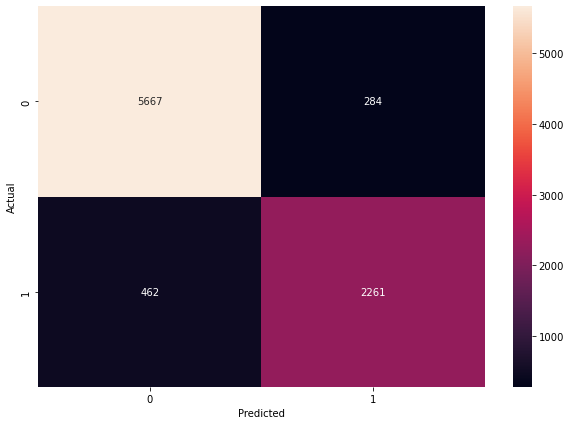

In [56]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(f'Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nF1_score: {f1_score}')